In [47]:
!pip install -q nibabel tf-keras-vis lime shap scikit-image


In [54]:
import os, random, re, zipfile, glob
from pathlib import Path
import numpy as np, cv2, matplotlib.pyplot as plt, tensorflow as tf
from tensorflow.keras import layers, models

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [57]:
BASE_DIR = Path("/content/brats18")          # adjust if different
IMG_DIR  = BASE_DIR / "images"
MASK_DIR = BASE_DIR / "masks"

img_files  = sorted(IMG_DIR.rglob("*.png"))
mask_files = sorted(MASK_DIR.rglob("*.png"))

print("images :", len(img_files))
print("masks  :", len(mask_files))
assert img_files and mask_files, "no files found – check BASE_DIR"


images : 5042
masks  : 5042


In [59]:
def extract_digits(p: Path) -> str:
    m = re.search(r"\d+", p.stem)
    return m.group(0) if m else p.stem

imgs_dict  = {extract_digits(p): p for p in img_files}
masks_dict = {extract_digits(p): p for p in mask_files}
common_keys = sorted(imgs_dict.keys() & masks_dict.keys())

print("matched pairs :", len(common_keys))
assert common_keys, "no matching filenames"


matched pairs : 5042


In [60]:
CLASSES = 5
TARGET  = 112
PATCH   = 65
BATCH   = 32

def load_image(path: Path) -> np.ndarray:
    img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(path)
    return img.astype(np.float32) / 255.0

def load_mask(path: Path) -> np.ndarray:
    msk = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if msk is None:
        raise FileNotFoundError(path)
    return (msk // (256 // CLASSES)).clip(0, CLASSES - 1).astype(np.int32)


In [61]:
data = []
for k in common_keys:
    img = load_image(imgs_dict[k])
    msk = load_mask(masks_dict[k])
    img = cv2.resize(img, (TARGET, TARGET))
    msk = cv2.resize(msk, (TARGET, TARGET), interpolation=cv2.INTER_NEAREST)
    data.append((img[..., None], msk))

random.shuffle(data)
split = int(0.8 * len(data))
train_data, val_data = data[:split], data[split:]

print("train :", len(train_data))
print("val   :", len(val_data))


train : 4033
val   : 1009


In [62]:
def make_dataset(pairs, shuffle=True):
    def gen():
        for img, msk in pairs:
            ys, xs = np.where(msk > 0)
            if len(ys):
                idx = random.randrange(len(ys))
                cy, cx = ys[idx], xs[idx]
            else:
                cy, cx = random.randrange(TARGET), random.randrange(TARGET)
            y1 = np.clip(cy - PATCH // 2, 0, TARGET - PATCH)
            x1 = np.clip(cx - PATCH // 2, 0, TARGET - PATCH)
            yield (img[y1:y1 + PATCH, x1:x1 + PATCH, :],
                   msk[y1:y1 + PATCH, x1:x1 + PATCH])

    ds = tf.data.Dataset.from_generator(
        gen,
        output_types=(tf.float32, tf.int32),
        output_shapes=((PATCH, PATCH, 1), (PATCH, PATCH))
    )
    if shuffle:
        ds = ds.shuffle(1024, seed=SEED)
    return ds.batch(BATCH).prefetch(tf.data.AUTOTUNE)

train_ds = make_dataset(train_data)
val_ds   = make_dataset(val_data, shuffle=False)


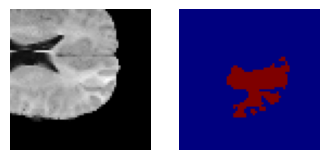

In [63]:
img_b, msk_b = next(iter(train_ds))
plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1); plt.imshow(img_b[0, ..., 0], cmap="gray"); plt.axis("off")
plt.subplot(1, 2, 2); plt.imshow(msk_b[0], cmap="jet");         plt.axis("off")
plt.show()


In [64]:
def two_path_cnn(input_shape=(PATCH, PATCH, 1), n_classes=CLASSES):
    inp = layers.Input(input_shape)

    x1 = layers.Conv2D(32, 3, padding="same", activation="relu")(inp)
    x1 = layers.Conv2D(64, 3, padding="same", activation="relu")(x1)

    x2 = layers.Conv2D(32, 5, padding="same", activation="relu")(inp)
    x2 = layers.Conv2D(64, 5, padding="same", activation="relu")(x2)

    x = layers.Concatenate()([x1, x2])
    x = layers.Conv2D(n_classes, 1, padding="same")(x)
    out = layers.Activation("softmax")(x)

    return models.Model(inp, out)

model = two_path_cnn()
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 65, 65, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 65, 65,    │        320 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 65, 65,    │        832 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 65, 65,    │     18,496 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 65, 65,    │     51,264 │ conv2d_8[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 65, 65,    │          0 │ conv2d_7[0][0],   │
│ (Concatenate)       │ 128)              │            │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 65, 65, 5) │        645 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 65, 65, 5) │          0 │ conv2d_10[0][0]   │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 71,557 (279.52 KB)

 Trainable params: 71,557 (279.52 KB)

 Non-trainable params: 0 (0.00 B)

In [65]:
history = model.fit(
    train_ds.repeat(),
    validation_data=val_ds,
    steps_per_epoch=200,
    epochs=15,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2)
    ],
    verbose=1
)


Epoch 1/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.8970 - loss: 0.5655 - val_accuracy: 0.9269 - val_loss: 0.1788 - learning_rate: 0.0010
Epoch 2/15
  7/200 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9384 - loss: 0.1665

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.9341 - loss: 0.1706 - val_accuracy: 0.9195 - val_loss: 0.1862 - learning_rate: 0.0010
Epoch 3/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9359 - loss: 0.1655 - val_accuracy: 0.9360 - val_loss: 0.1648 - learning_rate: 0.0010
Epoch 4/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9381 - loss: 0.1605 - val_accuracy: 0.9321 - val_loss: 0.1744 - learning_rate: 0.0010
Epoch 5/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9387 - loss: 0.1578 - val_accuracy: 0.9357 - val_loss: 0.1593 - learning_rate: 0.0010
Epoch 6/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9427 - loss: 0.1494 - val_accuracy: 0.9361 - val_loss: 0.1632 - learning_rate: 0.0010
Epoch 7/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.9446 - loss: 0.1439 - val_accuracy: 0.9318 - val_loss: 0.1617 - learning_rate: 0.0010
Epoch 8/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.9431 - loss: 0.1459 - va

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


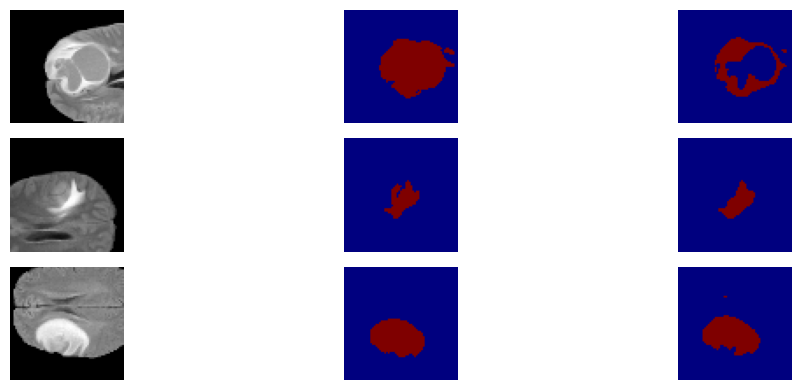

In [66]:
val_imgs, val_msks = next(iter(val_ds))
pred = model.predict(val_imgs)
pred_lbl = np.argmax(pred, axis=-1)

plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(3, 3, 3*i+1); plt.imshow(val_imgs[i, ..., 0], cmap="gray"); plt.axis("off")
    plt.subplot(3, 3, 3*i+2); plt.imshow(val_msks[i],        cmap="jet");  plt.axis("off")
    plt.subplot(3, 3, 3*i+3); plt.imshow(pred_lbl[i],        cmap="jet");  plt.axis("off")
plt.tight_layout(); plt.show()


In [80]:
# grab one validation patch
sample_img, sample_mask = next(iter(val_ds))
x = sample_img[0:1]      # shape (1, 65, 65, 1)
target_class = 1         # choose class to explain (0‑4)


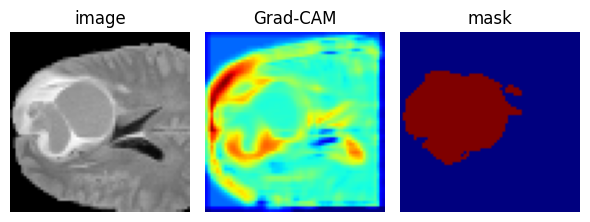

In [81]:
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear   # <─ new name

target_class = 4                       # 0‑4
score   = CategoricalScore(target_class)
gradcam = Gradcam(model,
                  model_modifier=ReplaceToLinear(),   # <─ here
                  clone=True)

cam = gradcam(score, x, penultimate_layer=-3)[0]

plt.figure(figsize=(6,3))
plt.subplot(1,3,1); plt.imshow(x[0,...,0], cmap='gray'); plt.axis('off'); plt.title('image')
plt.subplot(1,3,2); plt.imshow(cam, cmap='jet');         plt.axis('off'); plt.title('Grad‑CAM')
plt.subplot(1,3,3); plt.imshow(sample_mask[0], cmap='jet'); plt.axis('off'); plt.title('mask')
plt.tight_layout(); plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

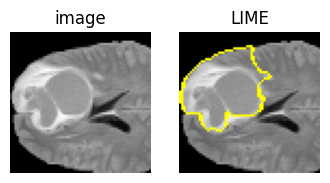

In [83]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

# tensor → numpy → [0‑255] uint8
gray = (x[0, ..., 0].numpy() * 255).astype(np.uint8)     # (65,65)
rgb  = np.repeat(gray[..., None], 3, axis=-1)             # → (65,65,3)

def predict_lime(batch):
    # batch arrives as uint8 RGB; convert back to model input
    gray_in = batch[..., 0:1] / 255.0                     # keep one channel
    preds   = model(gray_in).numpy()                      # (n,65,65,5)
    center  = preds[:, PATCH // 2, PATCH // 2, target_class]
    return np.stack([1 - center, center], axis=1)         # binary prob

explainer   = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    image         = rgb,
    classifier_fn = predict_lime,
    hide_color    = 0,
    num_samples   = 1000
)

temp, mask = explanation.get_image_and_mask(
    label          = 1,        # positive label of our binary output
    positive_only  = True,
    hide_rest      = False,
    num_features   = 5
)

plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1); plt.imshow(gray, cmap="gray");             plt.axis("off"); plt.title("image")
plt.subplot(1, 2, 2); plt.imshow(mark_boundaries(temp, mask));   plt.axis("off"); plt.title("LIME")
plt.show()


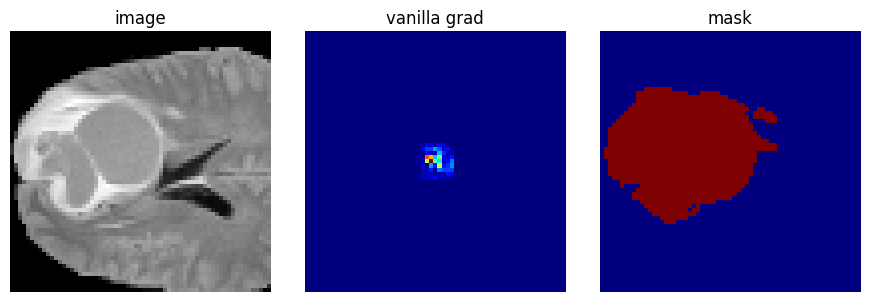

In [109]:
import tensorflow as tf, numpy as np, matplotlib.pyplot as plt

# sample patch (x) already prepared: shape (1, PATCH, PATCH, 1)
target_class = 4                      # class to explain (0‑4)

with tf.GradientTape() as tape:
    tape.watch(x)                      # make input differentiable
    pred = model(x)                    # (1, 65, 65, 5)
    # scalar focus: prob of target_class at patch centre
    loss = pred[:, PATCH // 2, PATCH // 2, target_class]

grads = tape.gradient(loss, x)[0, ..., 0].numpy()   # (65,65)
sal   = np.abs(grads)                               # vanilla gradient
sal   = (sal - sal.min()) / (sal.max() - sal.min() + 1e-8)  # 0‑1 scale

plt.figure(figsize=(9,3))
plt.subplot(1,3,1); plt.imshow(x[0, ..., 0], cmap="gray"); plt.axis("off"); plt.title("image")
plt.subplot(1,3,2); plt.imshow(sal, cmap="jet");           plt.axis("off"); plt.title("vanilla grad")
plt.subplot(1,3,3); plt.imshow(sample_mask[0], cmap="jet");plt.axis("off"); plt.title("mask")
plt.tight_layout(); plt.show()


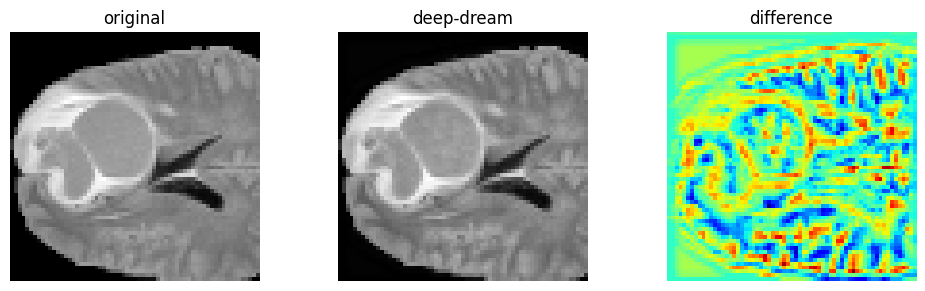

In [112]:
import tensorflow as tf, numpy as np, matplotlib.pyplot as plt

dream_layer   = 6      # Conv2D layer to amplify
dream_filter  = 4      # filter index
steps         = 100    # gradient‑ascent iterations
step_size     = 1e-2   # learning rate
octave_scale  = 1.0    # keep 1.0 for single‑scale (no octaves)

# ----- build a model that outputs activation of the chosen filter -----
layer_out = model.layers[dream_layer].output[..., dream_filter]           # (None,H,W)
dream_model = tf.keras.Model(model.input, layer_out)

# ----- start from the validation patch (x) -----
img = tf.Variable(x[0])                       # (65,65,1) float32

for i in range(steps):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = tf.reduce_mean(dream_model(img[None, ...]))  # scalar
    grads = tape.gradient(loss, img)
    grads = tf.math.l2_normalize(grads)        # normalise for stability
    img.assign_add(step_size * grads)

dream = img.numpy().squeeze()
dream = np.clip(dream, 0.0, 1.0)

plt.figure(figsize=(10,3))
plt.subplot(1,3,1); plt.imshow(x[0, ..., 0], cmap='gray');  plt.title('original'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(dream,        cmap='gray');  plt.title('deep‑dream'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(dream - x[0, ..., 0], cmap='jet'); plt.title('difference'); plt.axis('off')
plt.tight_layout(); plt.show()
